In [0]:
#クラスラベルの日本語化
! pip install japanize-matplotlib

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# ルートディレクトリを指定
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# pathにルートディレクトリを追加
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# pathに(ルートディレクトリ+samples/coco/)を追加
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco

%matplotlib inline 

# logとmodelの保存用ディレクトリを作成
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# 訓練済み重みファイルのパスを指定
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# 訓練済み重みファイルのパスが存在していなければ訓練済み重みファイルをダウンロード
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
import colorsys
from skimage.measure import find_contours
from matplotlib import patches,  lines
from matplotlib.patches import Polygon


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


#transposed_maskとfile_name引数を追加
def display_instances(image, boxes, masks, class_ids, class_names, transposed_mask, file_name,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        
        #確信度の域値設定
        if scores[i] <= 0.90:
                continue
                
        #color = colors[i]
        color = (0.0, 1.0, 0.0)
        

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            
            score = scores[i] if scores is not None else None
            
            label = class_names[class_id]
            #ここにtransposed_mask[i].sum()を追加して面積表示
            caption = "{} {:.1%}\nArea:{}".format(label, score, transposed_mask[i].sum()) if score else label
            
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='black', size=13, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    
    #画像を保存するかどうか
    save_image = True
    if save_image:
        #保存先は都度変更
        plt.savefig('/content/masked_{}'.format(file_name))
    
    if auto_show:
        plt.show()

Processing 1 images
image                    shape: (394, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


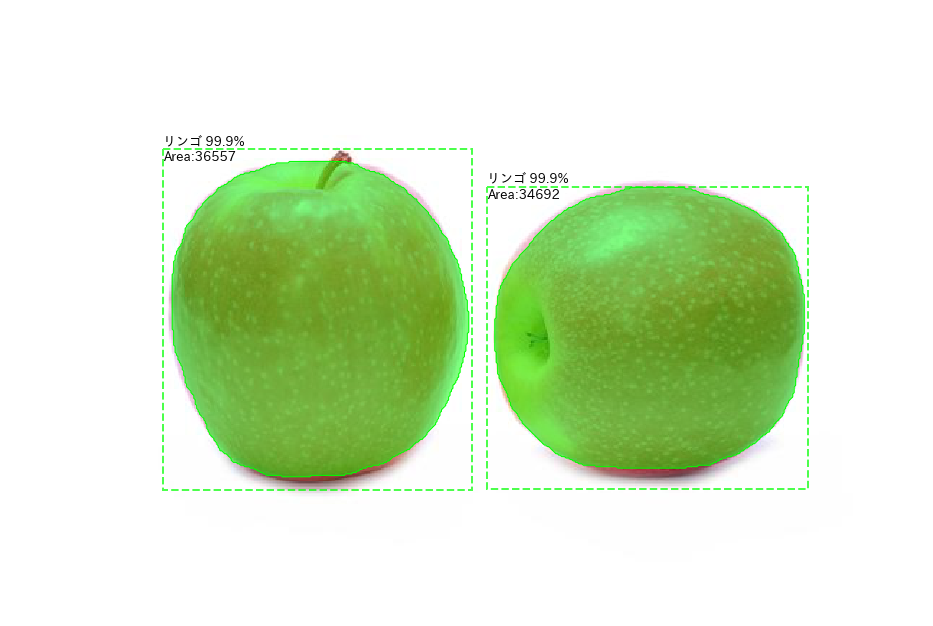

In [0]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# modelインスタンス準備
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# modelに訓練済み重みをロード
model.load_weights(COCO_MODEL_PATH, by_name=True)


# COCO Class names
class_names_jp = ['BG', '人間','自転車','車','オートバイ','飛行機',
                  'バス','電車','トラック','ボート','信号',
                '消火栓','一時停止','パーキングメーター','ベンチ','鳥',
                '猫','犬','馬','羊','牛','象','熊',
                'シマウマ','キリン','バックパック','傘','ハンドバッグ','ネクタイ',
                'スーツケース','フリスビー','スキー','スノーボード','スポーツボール',
                'カイト','バット','グローブ','スケートボード',
                'サーフボード','テニスラケット','ボトル','ワイングラス','カップ',
                'フォーク','ナイフ', 'スプーン', 'ボウル', 'バナナ','リンゴ',
                'サンドイッチ','オレンジ', 'ブロッコリー', 'ニンジン', 'ホットドッグ','ピザ',
                'ドーナツ','ケーキ','椅子','ソファ','鉢植え','ベッド',
                'ダイニングテーブル','トイレ','テレビ','ノートパソコン','マウス','リモート',
                'キーボード','携帯電話','電子レンジ','オーブン','トースター',
                '流し','冷蔵庫','本','時計','花瓶','はさみ',
                'テディベア','ドライヤー','歯ブラシ']



# IMAGE_DIRから写真の取り出し
IMAGE_DIR2 = "image"
file_names = next(os.walk(IMAGE_DIR2))[2]


for file_name in file_names:
    image = skimage.io.imread(os.path.join(IMAGE_DIR2, file_name))
    
    # 検知実行
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    
    ######## maskされた部分の面積測定 ########
    transposed_mask = results[0]["masks"].transpose(2,0,1)

    display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names_jp,transposed_mask, file_name, r['scores'])
    